In [1]:
# Imports

import numpy as np
import numpy.linalg as la
import scipy.linalg.interpolative as sli
import matplotlib as mp
import matplotlib.cm as cm
import scipy

from scipy.misc import imresize
from scipy.fftpack import dct
from scipy.ndimage import interpolation

# if available import pylab (from matlibplot)
try:
    import matplotlib.pylab as plt
except ImportError:
    pass

In [2]:
import scipy.io.wavfile as wavfile
from IPython.display import Audio

In [3]:
first_half = lambda l: l[1:(1+len(l)/2)]
power = lambda z: np.absolute(z)

def frequencies(f, Fs):
    x = np.linspace(0, Fs, len(f), endpoint=False)
    x[len(f)/2:] -= Fs # second half starts at lowest negative frequency
    return x

def freqcompare(y, Fs):
    powerfft = power(np.fft.fft(y))
    x = frequencies(y, Fs)
    plt.subplot(1,2,1)
    plt.plot(np.arange(len(y))*1./Fs, y)
    plt.xlim(0,len(y)*1./Fs)
    plt.ylim(min(y)-1,max(y)+1)
    plt.subplot(1,2,2)
    plt.plot(x, powerfft)
    plt.xlim(min(x)-1,max(x)+1)
    plt.ylim(0,max(powerfft)+1)
    plt.show()

nearest_2power = lambda x: int(np.log2(x))

In [4]:
semitone = 2.**(1./12.)

def genNotes(octaves):
    # instead of multiplying by 2^(1/12) over and over, we reduce drift/error
    # by creating all the C tones, which are multiples of 2 away from each other
    c_freqs = np.array([130.81*(2**i) for i in range(octaves)])
    ratios = np.array([semitone**i for i in range(12)]) 
    return np.dot(c_freqs[:, None], ratios[None, :]).flatten() # indexing with "None" adds an empty dimension

notes = genNotes(octaves=5)

# add an extra note below and above, so the dividing lines for the first and last C get computed properly
notes_expanded = np.concatenate(([notes[0]/semitone], notes, [notes[-1]*semitone]))
dividers = (notes_expanded[:-1]+notes_expanded[1:])/2. # calc dividing lines using average
dividers = np.array([dividers[:-1],dividers[1:]]).T # make each element a pair of dividing lines

def note_power(power, Fs):
    x = frequencies(power, Fs)
    return np.array([max(power[(x >= left) & (x < right)]) for left,right in dividers])


In [5]:
# some tests to make sure my key is correct

tone = lambda freq, t=8., Fs=44100., angle=0.: np.cos(freq*2*np.pi*np.linspace(0, t, Fs*t, endpoint=False)+angle)

def playFreq(freq):
    t = 8. # 8 seconds
    Fs = 44100.
    return Audio(tone(freq,t,Fs), rate=Fs)


## Multiple Instruments

In [6]:
Fs, rawsakae = wavfile.read('sakaeinaction.wav')

print Fs # make sure Fs matches all previous Fs
print rawsakae.shape

44100
(8353916L, 2L)


In [7]:
# reformat the data to match output of octave's wavread (divide by INT_MAX to normalize amplitude to [-1,1])
rawsakae1 = (rawsakae*1.)/np.iinfo(rawsakae[0][0]).max
rawsakae1 = rawsakae1[:,0] # only keep the first track

sakae = rawsakae1[:2**nearest_2power(rawsakae1.shape[0])] # clip end to make data length a power of 2

In [65]:
sakae_beginning = sakae[:2**18]

In [9]:
sakae_offset = sakae[44100:]

In [10]:
class Sampler:
    def __init__(self, song, N, offset=0, Fs=44100.):
        self.song = song
        self.N = N # sample size
        self.Fs = Fs
        self.w1_vec = np.fft.fft(np.arange(N) == 1) # extract the [1 w w^2 w^3...] vector using an fft of [0 1 0 0 0 ...]
        self.wN_vec = np.fft.fft(np.arange(N) == N-1) # extract the [1 w^(N-1) w^2(N-1) ...] using an fft of [0 0 0 ... 0 1]
        self.frequencies = frequencies(np.arange(self.N), self.Fs)
        self.reset(offset)
    
    def next(self):
        if (len(self.song) <= self.offset+self.N):
            return np.zeros(self.N) # song finished, just return zeros
        
        old_datum = self.song[self.offset]
        new_datum = self.song[self.offset+self.N]
        self.offset += 1
        self.dft = (self.dft-old_datum)/self.w1_vec + new_datum*self.wN_vec
        return self.dft
        
    def reset(self, offset=0):
        self.offset = offset
        self.dft = np.fft.fft(self.song[self.offset:self.offset+self.N])
        return self.dft
    
    def current_sample(self):
        return self.song[self.offset:self.offset+self.N]

In [11]:
sakaeSampler = Sampler(sakae_offset, 1024)

In [12]:
class DominantFrequencySampler(Sampler):
    def getDominantFrequencies(self, n=5):
        power_half = power(first_half(self.dft)[:-1]) # exclude the last frequency, because it *could* be the lowest negative freq
        top_powers = np.argpartition(power_half, -n)[-n:] # use argpartition to get indices of top n frequencies
        top_powers = top_powers[np.argsort(power_half[top_powers])][::-1] # sort the top frequency indices in descending order
        self.top_freqs = self.frequencies[top_powers+1] # add 1 because power_half starts at index 1 (not 0)
        self.top_magnitudes = power_half[top_powers]
        self.top_phases = np.angle(self.dft[top_powers+1])
        return (self.top_freqs, self.top_magnitudes, self.top_phases)

In [13]:
lowSampler = DominantFrequencySampler(sakae_offset, Fs/20)

In [14]:
sakae5Secs = sakae[:44100*5]

lowSampler2 = DominantFrequencySampler(sakae5Secs, Fs/20) # only look at first 5 seconds

In [15]:
oneSec = Fs # number of frames for 1 second

In [16]:
indx1760 = np.nonzero((lowSampler2.frequencies > 1755) & (lowSampler2.frequencies < 1765))[0][0] # index of freq ~880

A6PowerOverTime = power([lowSampler2.next()[indx1760] for i in range(oneSec*2)])

In [17]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n-1:] / n


### Shape

let's find where the power of A6 is the highest, and then extract the frequency shape

In [18]:
frequencyRange = np.nonzero((lowSampler2.frequencies > 0) & (lowSampler2.frequencies < 4000))

In [19]:
sakaeClash = rawsakae1[154*Fs:(154+5)*Fs]
Audio(sakaeClash[:2*Fs], rate=Fs)

100


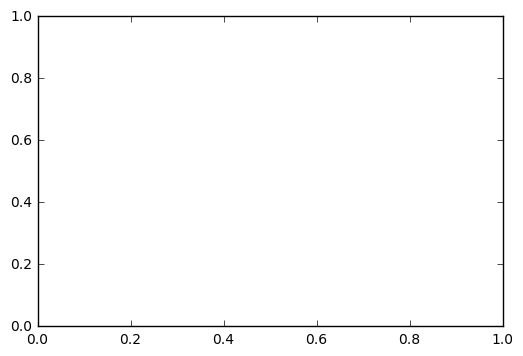

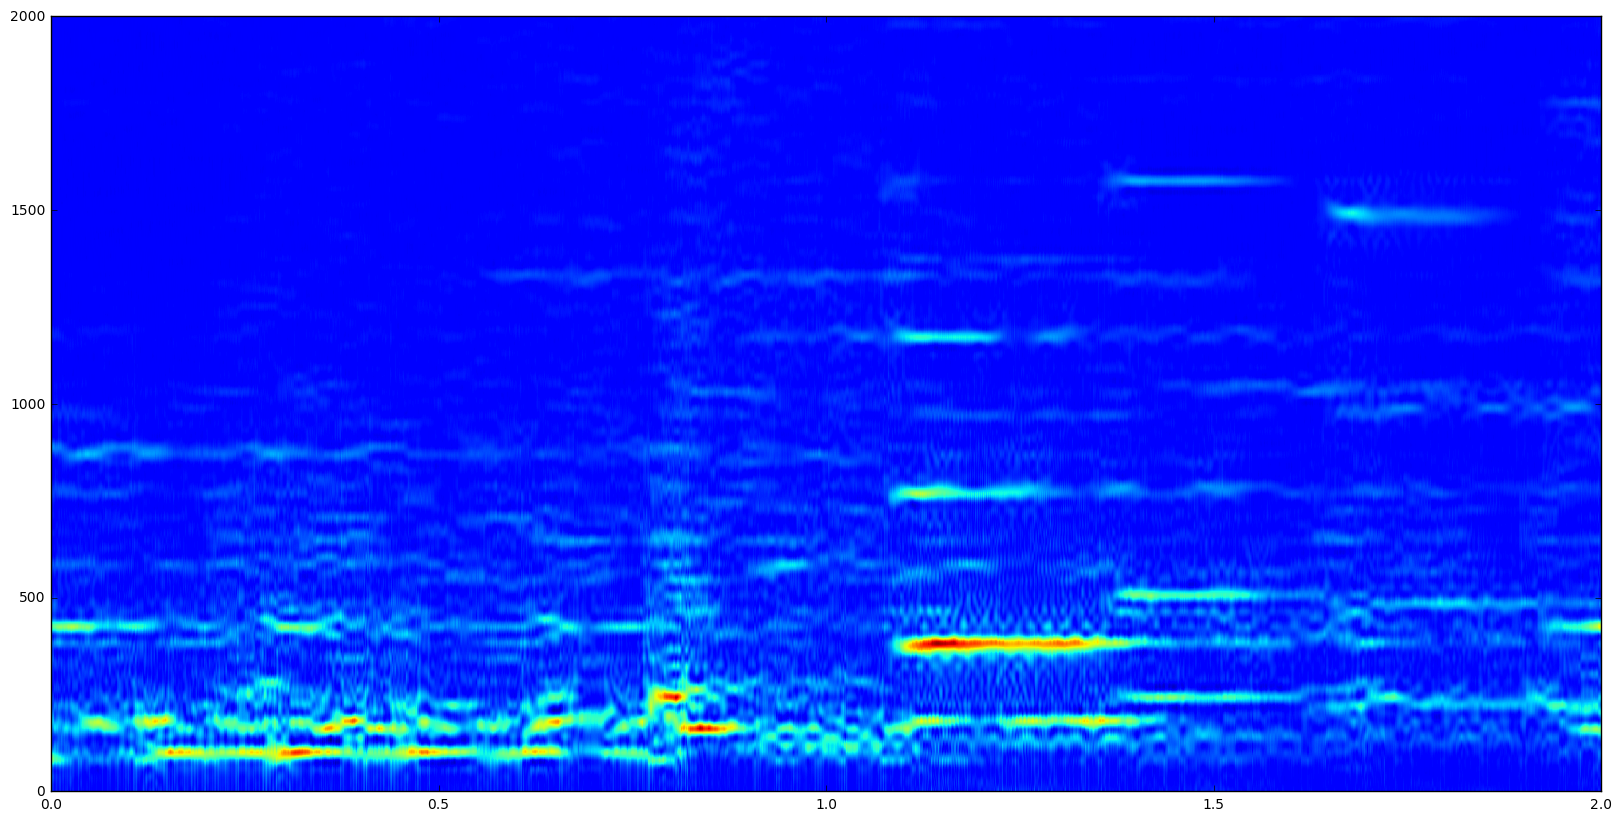

In [102]:
lowClashSampler = DominantFrequencySampler(sakaeClash, Fs/20)

freqCrop = len(first_half(lowClashSampler.frequencies)[first_half(lowClashSampler.frequencies) < 2000])
print freqCrop
average_over = 5 # average the data over 10 samples
spectrum = np.zeros((int(oneSec*2/average_over), freqCrop))
for i in range(int(oneSec*2/average_over)):
    spectrum[i] = np.mean([power(first_half(lowClashSampler.next())[:freqCrop]) for j in range(average_over)], axis=0)

plt.figure(figsize=(20,10))
spectrum = interpolation.zoom(spectrum, [1,20])
plt.imshow(spectrum.T, aspect='auto', interpolation='none', extent=[0,2,2000,0]) #np.linspace(0,2,oneSec*2,endpoint=False),
#plt.colorbar()
plt.gca().invert_yaxis()
plt.show()

200


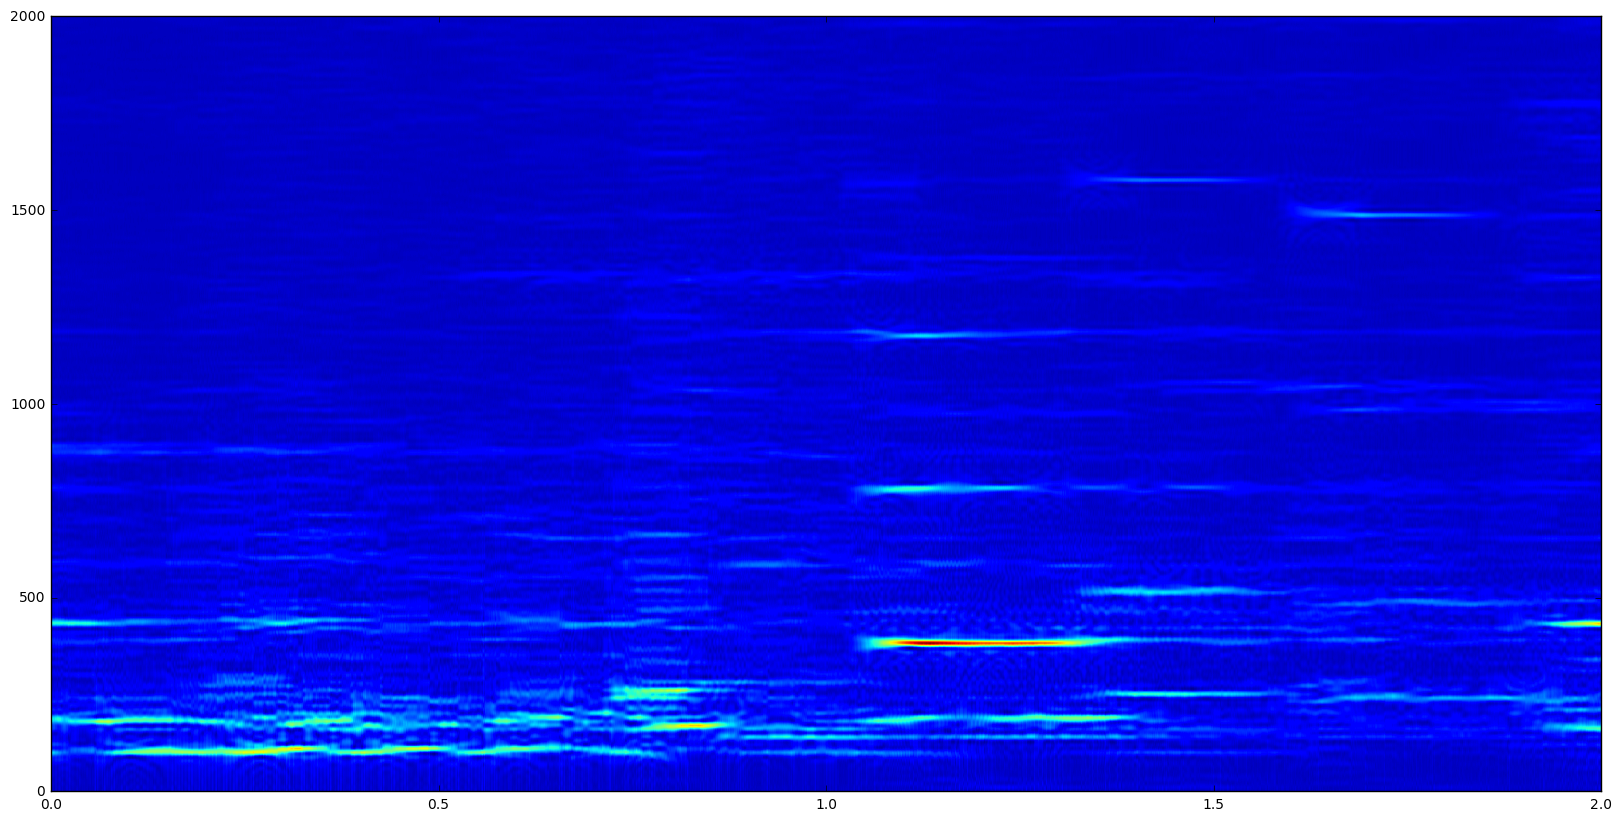

In [103]:
lowerClashSampler = DominantFrequencySampler(sakaeClash, Fs/10)

freqCrop = len(first_half(lowerClashSampler.frequencies)[first_half(lowerClashSampler.frequencies) < 2000])
print freqCrop
average_over = 5 # average the data over 10 samples
spectrum = np.zeros((int(oneSec*2/average_over), freqCrop))
for i in range(int(oneSec*2/average_over)):
    spectrum[i] = np.mean([power(first_half(lowerClashSampler.next())[:freqCrop]) for j in range(average_over)], axis=0)

plt.figure(figsize=(20,10))
spectrum = interpolation.zoom(spectrum, [1,20])
plt.imshow(spectrum.T, aspect='auto', interpolation='none', extent=[0,2,2000,0]) #np.linspace(0,2,oneSec*2,endpoint=False),
#plt.colorbar()
plt.gca().invert_yaxis()
plt.show()

100


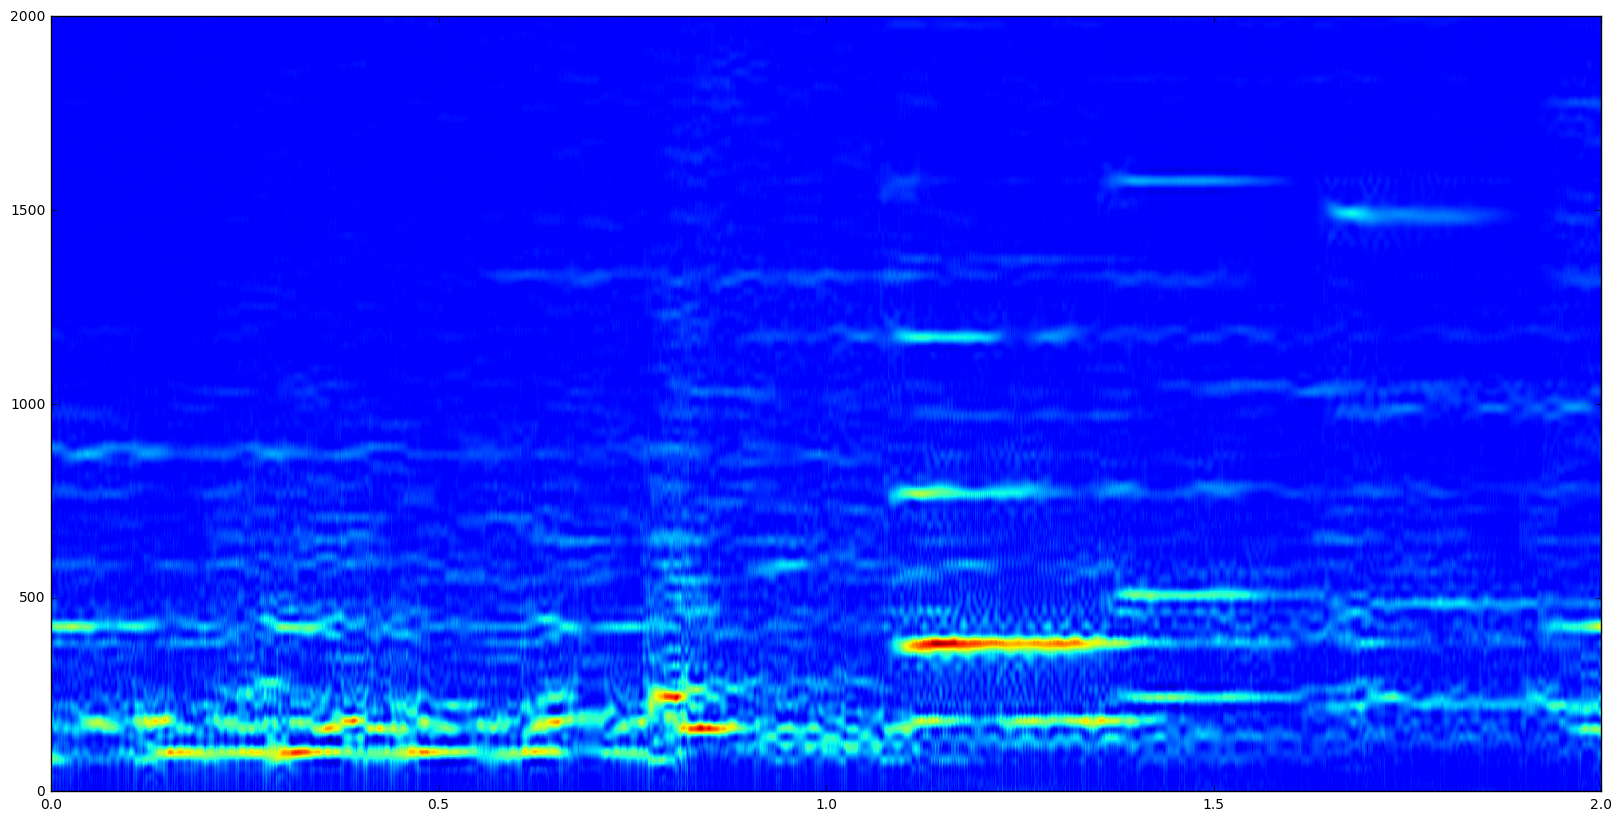

In [104]:
lowClashSampler = DominantFrequencySampler(sakaeClash, Fs/20)

freqCrop = len(first_half(lowClashSampler.frequencies)[first_half(lowClashSampler.frequencies) < 2000])
print freqCrop
average_over = 10 # average the data over 10 samples
spectrum = np.zeros((int(oneSec*2/average_over), freqCrop))
for i in range(int(oneSec*2/average_over)):
    spectrum[i] = np.mean([power(first_half(lowClashSampler.next())[:freqCrop]) for j in range(average_over)], axis=0)

plt.figure(figsize=(20,10))
spectrum = interpolation.zoom(spectrum, [1,20])
plt.imshow(spectrum.T, aspect='auto', interpolation='none', extent=[0,2,2000,0]) #np.linspace(0,2,oneSec*2,endpoint=False),
#plt.colorbar()
plt.gca().invert_yaxis()
plt.show()

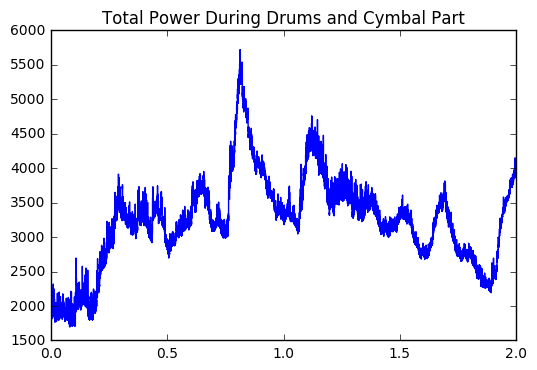

In [105]:
lowClashSampler.reset()

totalPowerOverTime = np.array([np.sum(power(first_half(lowClashSampler.next())[:-1])) for i in range(oneSec*2)])

plt.plot(np.linspace(0, 2, oneSec*2), totalPowerOverTime)
plt.title("Total Power During Drums and Cymbal Part")
plt.show()

## Difference Averaging

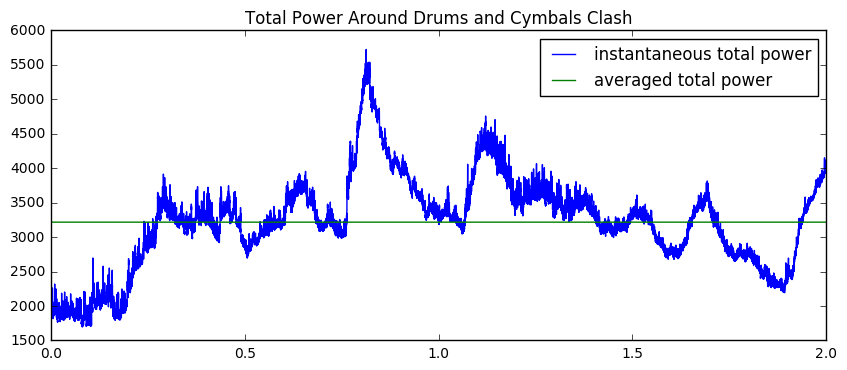

In [106]:
averagePower = np.sum(totalPowerOverTime)/(oneSec*2)

plt.figure(figsize=(10,4))
plt.hold(True)
plt.plot(np.linspace(0,2,oneSec*2,endpoint=False), totalPowerOverTime, label="instantaneous total power")
plt.plot(np.linspace(0,2,oneSec*2,endpoint=False), np.full(oneSec*2, averagePower), label="averaged total power")
plt.title("Total Power Around Drums and Cymbals Clash")
plt.legend()
plt.show()
plt.hold(False)

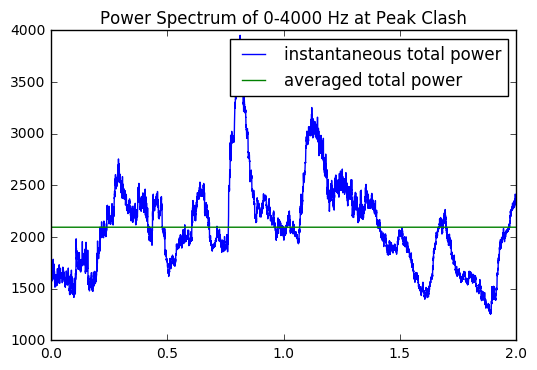

In [107]:
lowClashSampler.reset()

totalPowerOverTimeCropped = []
for i in range(oneSec*2):
    lowClashSampler.next()
    totalPowerOverTimeCropped = np.append(totalPowerOverTimeCropped, np.sum(power(lowClashSampler.dft[frequencyRange])))

#totalPowerOverTimeCropped = np.array([np.sum(power(lowClashSampler.next()[frequencyRange])) for i in range(oneSec*2)])
averagePowerCropped = np.mean(totalPowerOverTimeCropped)

plt.hold(True)
plt.plot(np.linspace(0,2,oneSec*2,endpoint=False), totalPowerOverTimeCropped, label="instantaneous total power")
plt.plot(np.linspace(0,2,oneSec*2,endpoint=False), np.full(oneSec*2, averagePowerCropped), label="averaged total power")
plt.title("Power Spectrum of 0-4000 Hz at Peak Clash")
plt.legend()
plt.show()
plt.hold(False)

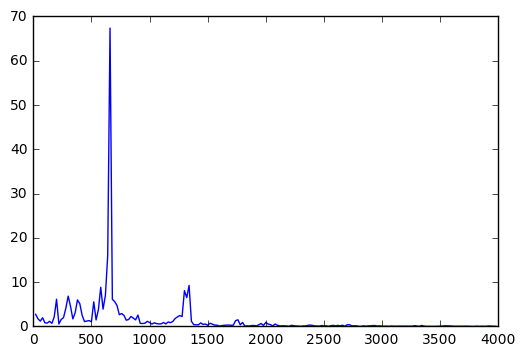

In [108]:
test = oneSec+np.argmax(totalPowerOverTimeCropped[oneSec:int(oneSec*1.5)])
plt.plot(lowSampler.frequencies[frequencyRange], power(lowSampler.reset(offset=test)[frequencyRange]))
plt.show()

In [109]:
testi = frequencyRange[0][np.argmax(power(lowSampler.dft[frequencyRange]))]
lowSampler.frequencies[testi]

660.0

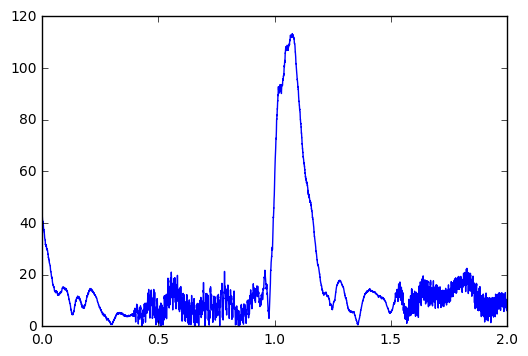

In [110]:
lowSampler.reset()
test2 = np.array([lowSampler.next()[testi] for i in range(oneSec*2)])

plt.plot(np.linspace(0,2,len(test2),endpoint=False), power(test2))
plt.show()

In [111]:
# perhaps later I can fine tune this. For example, if there's a constant bass in the background, we still want to
# register the smaller notes on top, but we don't want to register too much (eg noise).
# maybe averaging total power over 1 second will take care of that
averageDifference = averagePowerCropped

lastNote = np.zeros(len(frequencyRange[0]))
lastNotePower = power(lastNote)
lastNoteIndex = 0
currNoteIndex = 0

lowClashSampler.reset()

for i in range(oneSec*2):
    powerDifference = power(lowClashSampler.next()[frequencyRange]) - lastNotePower
    total = np.sum(powerDifference.clip(min=0))
    if (total > averageDifference):
        currNoteIndex = lowClashSampler.offset
        break

print "first note at " + str(currNoteIndex*1./Fs) + " seconds"

first note at 0.210816326531 seconds


In [112]:
# we could potentially find the dominant frequencies in difference, and then track when those frequencies peak,
# and then find the instrument shape from there. For now, lets just take when the difference>averagePower, and then
# average over a couple samples. Actually this won't work because we need to find the peak of this note to optimize
# finding the next note

def getDominantFrequencies(dft, frequencies, n=5):
    power_half = power(first_half(dft)[:-1]) # exclude the last frequency, because it *could* be the lowest negative freq
    top_powers = np.argpartition(power_half, -n)[-n:] # use argpartition to get indices of top n frequencies
    top_powers = top_powers[np.argsort(power_half[top_powers])][::-1] # sort the top frequency indices in descending order
    top_freqs = frequencies[top_powers+1] # add 1 because power_half starts at index 1 (not 0)
    top_magnitudes = power_half[top_powers]
    top_phases = np.angle(dft[top_powers+1])
    return (top_freqs, top_magnitudes, top_phases, top_powers+1)

freqs = frequencies(lastNote, Fs)
top_freqs, _, _, top_freqs_indices = getDominantFrequencies(lastNote, freqs)

print top_freqs

[ 21717.5879397    7313.06532663   7977.88944724   7534.67336683
   7756.28140704]


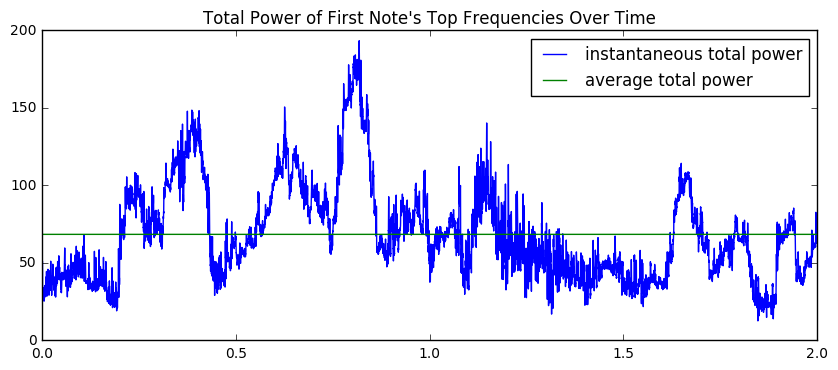

array([ 16.82045961 +0.j        ,  15.00267846 -4.44493673j,
        16.80133974 -5.91872747j, ...,  21.67753182+11.11455625j,
        16.80133974 +5.91872747j,  15.00267846 +4.44493673j])

In [113]:
temp = lowClashSampler.offset
startPower = np.sum(power(lowClashSampler.reset()[top_freqs_indices]))

topfreqspower = [np.sum(power(lowClashSampler.next()[top_freqs_indices])) for i in range(oneSec*2-1)]
topfreqspower = np.append([startPower], topfreqspower)
averagetopfreqspower = np.mean(topfreqspower)

plt.figure(figsize=(10,4))
plt.hold(True)
plt.plot(np.linspace(0, 2, len(topfreqspower), endpoint=False), topfreqspower, label="instantaneous total power")
plt.plot(np.linspace(0, 2, len(topfreqspower), endpoint=False), np.full(len(topfreqspower), averagetopfreqspower), label="average total power")
plt.title("Total Power of First Note's Top Frequencies Over Time")
plt.legend()
plt.hold(False)
plt.show()

lowClashSampler.reset(temp)

In [114]:
# to find where it peaks, take an average slope for around 0.1 seconds, and then ...

# another way: record current power of dominant frequencies, and record when dominant frequencies dip below that. Then
# take the maximum in that time range

print currNoteIndex

i = currNoteIndex
startPower = topfreqspower[i]
print startPower
currPower = startPower
peakCurrNote = None
peakCurrNoteIndex = i
peakPower = currPower
while (currPower >= startPower):
    if (currPower > peakPower):
        peakCurrNote = lowClashSampler.reset(i)
        peakCurrNoteIndex = i
    i += 1
    currPower = topfreqspower[i]

print peakCurrNoteIndex
print peakCurrNoteIndex - currNoteIndex

9297
78.4134006784
9314
17


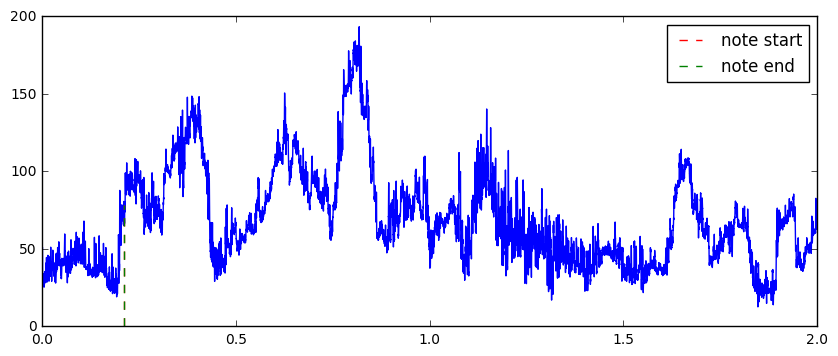

In [115]:
plt.figure(figsize=(10,4))
plt.hold(True)
plt.plot(np.linspace(0, 2, len(topfreqspower), endpoint=False), topfreqspower, 'b')
plt.plot(np.array([currNoteIndex,currNoteIndex])*2./len(topfreqspower), [0,topfreqspower[currNoteIndex]], 'r--', label="note start")
plt.plot(np.array([peakCurrNoteIndex,peakCurrNoteIndex])*2./len(topfreqspower), [0,topfreqspower[peakCurrNoteIndex]], 'g--', label="note end")
plt.legend()
plt.hold(False)
plt.show()

thats not right, almost immediately dips below average power. Lets just look at the timbre anyways

In [116]:
plt.hold(True)
plt.plot(lowClashSampler.frequencies[frequencyRange], clashPowerSpectrum, label="instantaneous")
plt.plot(lowClashSampler.frequencies[frequencyRange], averagedClashPowerSpectrum, label="averaged 200")
plt.title("Power Spectrum at Peak Clash")
plt.legend()
plt.show()
plt.hold(False)

NameError: name 'clashPowerSpectrum' is not defined

### Double Rolling Average

In [58]:
# tweak these until you get a good graph
longWindow = 10000
shortWindow = 1000


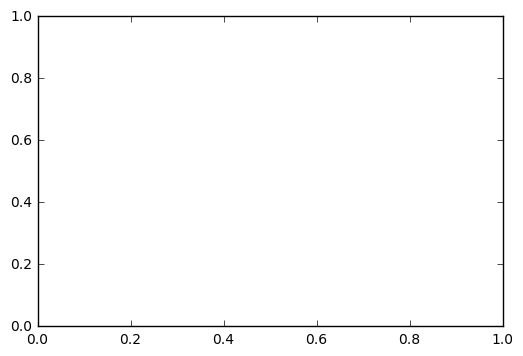

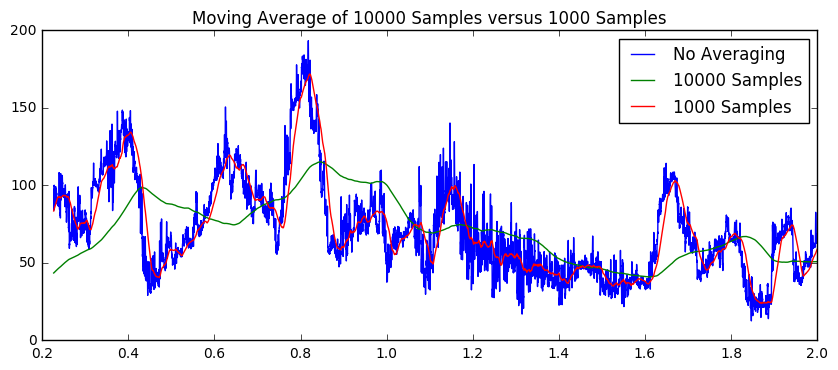

In [117]:

startIndex = longWindow
# start at (index-window) to get a rolling average looking backwards (the value at i should be the average from (i-window) to i)
longAverage = moving_average(topfreqspower[startIndex-longWindow:], longWindow)
shortAverage = moving_average(topfreqspower[startIndex-shortWindow:], shortWindow)
averagingRange = np.linspace(startIndex*1./Fs, 2, len(longAverage), endpoint=False)

plt.figure(figsize=(10,4))
plt.hold(True)
plt.plot(averagingRange, topfreqspower[startIndex-1:], label="No Averaging")
plt.plot(averagingRange, longAverage, label="10000 Samples")
plt.plot(averagingRange, shortAverage, label="1000 Samples")
plt.title("Moving Average of 10000 Samples versus 1000 Samples")
plt.legend()
plt.show()
plt.hold(False)

NOW THATS WHAT IM TALKING ABOUT
each note is an interval where the red line is above the green line.

However, listening to the music, the "note" that starts at 0.2 seconds is a gradual crescendo of cymbals, and it seems to last until 0.8 seconds (the drum clash). Looking at the spectrometer graph, it looks around the same, except for a few small gaps around 0.6 seconds. What is probably happening is that, because the cymbals have a lot of frequencies involved, if I only take the top 5 that occur in the beginning, I am probably missing out on a lot of other frequencies that are part of the cymbals. While the initial 5 dominant frequencies might have gaps, as long as the other frequencies make up for it, then it sounds like one continuous cymbal note. This is also due to the fact that cymbals are not really a single note and rather a bunch of notes played in quick succession that blur into one long sound, so a few gaps makes sense.

To test this, lets try applying the double moving average algorithm to the total power of all frequencies, not just the top 5 initial ones:

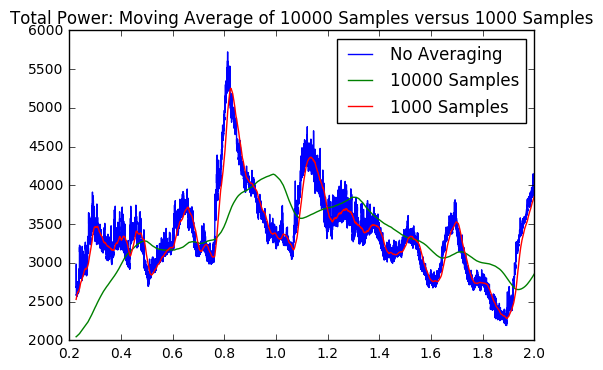

In [118]:
startIndex = longWindow
# start at (index-window) to get a rolling average looking backwards (the value at i should be the average from (i-window) to i)
longAverage = moving_average(totalPowerOverTime[startIndex-longWindow:], longWindow)
shortAverage = moving_average(totalPowerOverTime[startIndex-shortWindow:], shortWindow)
averagingRange = np.linspace(startIndex*1./Fs, 2, len(longAverage), endpoint=False)

plt.hold(True)
plt.plot(averagingRange, totalPowerOverTime[startIndex-1:], label="No Averaging")
plt.plot(averagingRange, longAverage, label="10000 Samples")
plt.plot(averagingRange, shortAverage, label="1000 Samples")
plt.title("Total Power: Moving Average of 10000 Samples versus 1000 Samples")
plt.legend()
plt.show()
plt.hold(False)

see, the gap is much less noticable now, showing that we weren't factoring in enough frequencies. Let's try averaging out the timbres for the first peak, and extracting the top frequencies for that

In [119]:
longAverage = moving_average(topfreqspower[startIndex-longWindow:], longWindow)
shortAverage = moving_average(topfreqspower[startIndex-shortWindow:], shortWindow)
indices = np.arange(len(longAverage))

peakStart = indices[shortAverage > longAverage][0]

print "peak starts at : " + str(averagingRange[peakStart])

peakEnd = peakStart + indices[peakStart:][longAverage[peakStart:] > shortAverage[peakStart:]][0]

print "peak ends at : " + str(averagingRange[peakEnd])

peak starts at : 0.226757369615
peak ends at : 0.433580121648


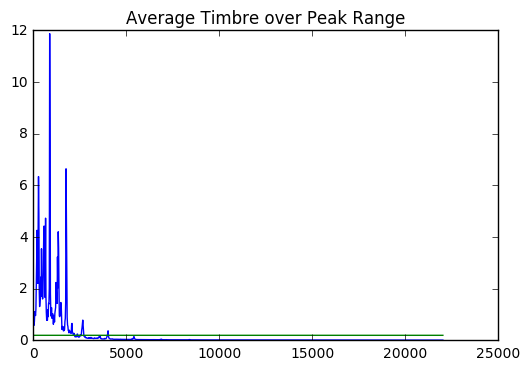

In [120]:
lowSampler.reset(startIndex+peakStart) # note: peakstart/peakend are relative to startIndex (where longAverage and shortAverage start)

averageTimbre = np.mean([power(first_half(lowSampler.next())[:-1]) for i in range(peakEnd-peakStart)], axis=0)
averageAverageTimbre = np.mean(averageTimbre)

plt.hold(True)
plt.plot(first_half(lowSampler.frequencies)[:-1], averageTimbre)
plt.plot(first_half(lowSampler.frequencies)[:-1], np.full(len(averageTimbre), averageAverageTimbre))
plt.title("Average Timbre over Peak Range")
plt.show()
plt.hold(False)

eh this is too complicated, because now we would need to first find the dominant frequencies, then find the first peak based on those dominant frequencies, then average the timbre over the first peak to recalculate the dominant frequencies, and then recalculate the first peak to find the true range of the note.

Instead, because our short moving average uses a window size of 1000 samples, lets just use that. For the first note, we use total power, find the start of the first peak, and then average the timbre over 1000 samples. Later on, for subsequent notes we can look at the total power of everything except the previous note's dominant frequencies

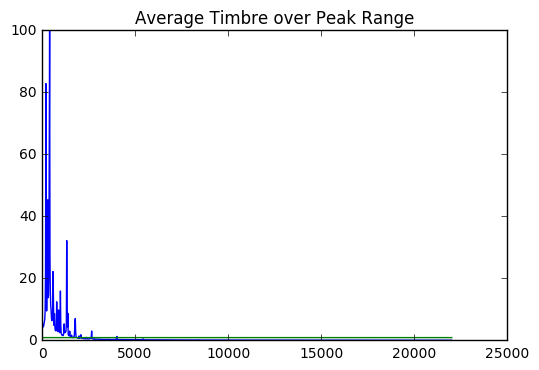

In [122]:
averageTimbre = np.mean([power(first_half(lowSampler.next())[:-1]) for i in range(peakEnd-peakStart)], axis=0)
averageAverageTimbre = np.mean(averageTimbre)

plt.hold(True)
plt.plot(first_half(lowSampler.frequencies)[:-1], averageTimbre)
plt.plot(first_half(lowSampler.frequencies)[:-1], np.full(len(averageTimbre), averageAverageTimbre))
plt.title("Average Timbre over Peak Range")
plt.show()
plt.hold(False)

the red line is the average of the graph. The idea is to take the frequencies that are above this average. That way, for instruments with lots of dominant frequencies, they would all be taken, but for instruments with only a few dominant frequencies, only those ones with be taken. However, clearly the frequency range is so high that the vast majority of frequency powers are ~0, so the average ends up being way too low.

A simple and dirty solution: take as many frequencies needed to sum up to 90% of the total sum.

However, sorting this many frequencies would take forever.

A quick and dirty solution: take all frequencies above average, re-calculate the average, and then take the frequencies above that average.

(Note: i wonder if we could fix the issues we have with the top-5-frequencies method with the 90% method. That is, our original issue was that some instruments have more spread out frequencies, so just calculating the top 5 wouldn't work. However, what at every sample, we calculated which frequencies added up to 90%. This would be must simpler than our method of using the previous note and taking the difference to look for the next note. We wouldn't even have to worry about the previous note using this method. However, one possible issues is one frequencies is like 89%, and there are another 11 frequencies around 1% each, then with noise these 11 frequencies are constantly going to be switching in and out of the top 90%. I think using the previous note lets us handle noise better)

In [123]:
def quickndirtyDominantFreqsIndices(timbre):
    firstAverage = np.mean(timbre)
    secondAverage = np.mean(timbre[timbre > firstAverage])
    return np.nonzero(timbre > secondAverage)[0]

 # add 1 because averageTimbre uses first_half(), which starts at index 1
topFreqsIndices = 1+quickndirtyDominantFreqsIndices(averageTimbre)

print lowSampler.frequencies[topFreqsIndices]

[  160.   180.   200.   220.   240.   260.   280.   300.   320.   340.
   360.   380.   400.   420.   440.   460.   480.   580.   600.   660.
   780.   880.   980.  1320.  1340.  1380.]


In [124]:
# note: top 90% was giving too many frequencies, so I tried top 50% instead

def top50PercentFreqs(timbre):
    power50perc = 0.5*np.sum(timbre)
    sortedindices = np.argsort(timbre) # note: ascending order
    sortedtimbre = timbre[sortedindices]
    cumulativeSum = np.cumsum(sortedtimbre)
    return sortedindices[cumulativeSum >= power50perc] # when cumulative sum surpasses 30%, the remaining numbers will sum to 70%

top50FreqsIndices = 1+top50PercentFreqs(averageTimbre)

print lowSampler.frequencies[top50FreqsIndices]

[  320.   340.   440.   600.   980.   180.   360.   580.   280.   420.
  1320.   300.   380.   200.   400.]


In [125]:
# measure the similarity between the methods

print lowSampler.frequencies[np.intersect1d(topFreqsIndices, top50FreqsIndices)]

[  180.   200.   280.   300.   320.   340.   360.   380.   400.   420.
   440.   580.   600.   980.  1320.]


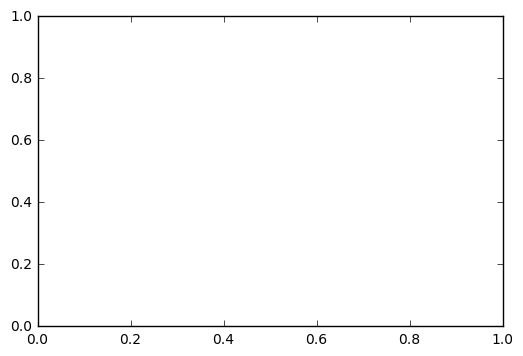

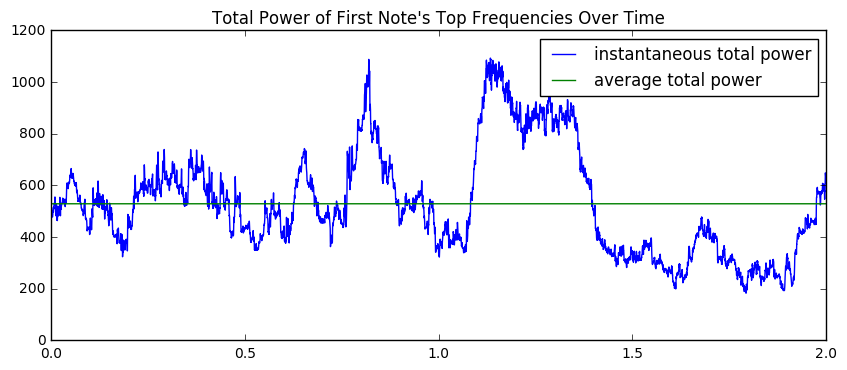

array([ 24.28315073+0.j        ,  22.65910882-3.49221795j,
        24.74218514-3.82397801j, ...,  30.48621851+7.1962791j ,
        24.74218514+3.82397801j,  22.65910882+3.49221795j])

In [126]:
temp = lowClashSampler.offset
startPower = np.sum(power(lowClashSampler.reset()[top50FreqsIndices]))

top50freqspower = [np.sum(power(lowClashSampler.next()[top50FreqsIndices])) for i in range(oneSec*2-1)]
top50freqspower = np.append([startPower], top50freqspower)
averagetop50freqspower = np.mean(top50freqspower)

plt.figure(figsize=(10,4))
plt.hold(True)
plt.plot(np.linspace(0, 2, len(top50freqspower), endpoint=False), top50freqspower, label="instantaneous total power")
plt.plot(np.linspace(0, 2, len(top50freqspower), endpoint=False), np.full(len(top50freqspower), averagetop50freqspower), label="average total power")
plt.title("Total Power of First Note's Top Frequencies Over Time")
plt.legend()
plt.show()
plt.hold(False)

lowClashSampler.reset(temp)

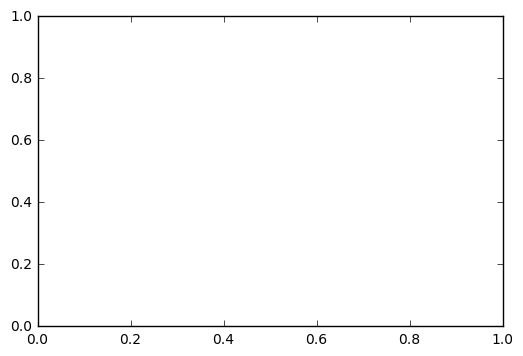

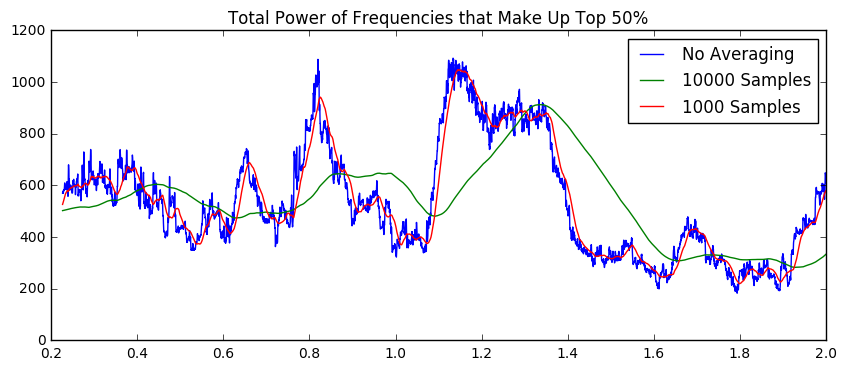

In [127]:
# tweak these until you get a good graph
longWindow = 10000
shortWindow = 1000

startIndex = longWindow
# start at (index-window) to get a rolling average looking backwards (the value at i should be the average from (i-window) to i)
longAverage = moving_average(top50freqspower[startIndex-longWindow:], longWindow)
shortAverage = moving_average(top50freqspower[startIndex-shortWindow:], shortWindow)
averagingRange = np.linspace(startIndex*1./Fs, 2, len(longAverage), endpoint=False)

plt.figure(figsize=(10,4))
plt.hold(True)
plt.plot(averagingRange, top50freqspower[startIndex-1:], label="No Averaging")
plt.plot(averagingRange, longAverage, label="10000 Samples")
plt.plot(averagingRange, shortAverage, label="1000 Samples")
plt.title("Total Power of Frequencies that Make Up Top 50%")
plt.legend()
plt.hold(False)
plt.show()

Lets look at the problematic area, the piano notes.

In [128]:
# note: top 90% was giving too many frequencies, so I tried top 50% instead

def top80PercentFreqs(timbre):
    power20perc = 0.2*np.sum(timbre)
    sortedindices = np.argsort(timbre) # note: ascending order
    sortedtimbre = timbre[sortedindices]
    cumulativeSum = np.cumsum(sortedtimbre)
    return sortedindices[cumulativeSum >= power20perc] # when cumulative sum surpasses 30%, the remaining numbers will sum to 70%

top80FreqsIndices = 1+top80PercentFreqs(averageTimbre)

print lowSampler.frequencies[top80FreqsIndices]

[ 1160.  1800.  1740.  1260.   920.   840.  1220.  1480.  1280.  2660.
   740.   860.   720.   700.   960.   820.   760.  1360.    60.    80.
    40.   640.  1000.   680.  1180.    20.   100.  1300.  1760.   120.
   620.   520.   540.   140.   500.  1780.   900.   800.   560.   660.
  1380.   240.   480.   880.   160.  1340.   460.   780.   260.   220.
   320.   340.   440.   600.   980.   180.   360.   580.   280.   420.
  1320.   300.   380.   200.   400.]


In [129]:
temp = lowClashSampler.offset
startPower = np.sum(power(lowClashSampler.reset()[top80FreqsIndices]))

top80freqspower = [np.sum(power(lowClashSampler.next()[top50FreqsIndices])) for i in range(oneSec*2-1)]
top80freqspower = np.append([startPower], top80freqspower)
averagetop50freqspower = np.mean(top50freqspower)

lowClashSampler.reset(temp)

array([ 24.28315073+0.j        ,  22.65910882-3.49221795j,
        24.74218514-3.82397801j, ...,  30.48621851+7.1962791j ,
        24.74218514+3.82397801j,  22.65910882+3.49221795j])

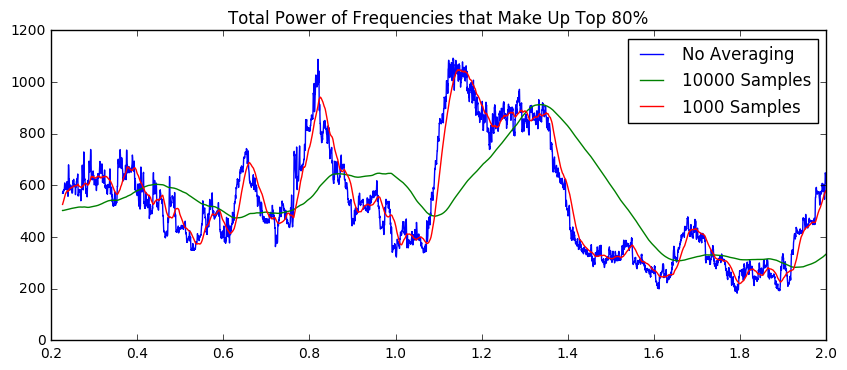

In [130]:
startIndex = longWindow
# start at (index-window) to get a rolling average looking backwards (the value at i should be the average from (i-window) to i)
longAverage = moving_average(top80freqspower[startIndex-longWindow:], longWindow)
shortAverage = moving_average(top80freqspower[startIndex-shortWindow:], shortWindow)
averagingRange = np.linspace(startIndex*1./Fs, 2, len(longAverage), endpoint=False)

plt.figure(figsize=(10,4))
plt.hold(True)
plt.plot(averagingRange, top80freqspower[startIndex-1:], label="No Averaging")
plt.plot(averagingRange, longAverage, label="10000 Samples")
plt.plot(averagingRange, shortAverage, label="1000 Samples")
plt.title("Total Power of Frequencies that Make Up Top 80%")
plt.legend()
plt.hold(False)
plt.show()

hmm, while top 50% was better than the graph for just the top 5 frequencies, the top 80% graph doesn't look like much improvement. Note that top 100% would just be the total power of all frequencies, and we already saw earlier that even in that graph, the cymbals seem to dip below the average for a bit. Not entirely sure how to fix this, so let's move onto the piano part:

In [22]:
# new values on the left (lower indices)
class RollingAverager:
    def __init__(self, initial):
        self.values = initial
        self.average = np.mean(self.values, axis=0)
        self.N = 1.*len(initial) # convert to double
    def nextSample(self, sample):
        self.average += (sample-self.values[-1])/self.N
        self.values = np.roll(self.values,1,axis=0)
        self.values[0] = sample
        return  self.average
    
test = RollingAverager(np.array([[1,1],[2,2]]))
for i in range (10):
    print test.nextSample([-20,20])


[ -9.5  10.5]
[-20.  20.]
[-20.  20.]
[-20.  20.]
[-20.  20.]
[-20.  20.]
[-20.  20.]
[-20.  20.]
[-20.  20.]
[-20.  20.]


(1000L, 199L)


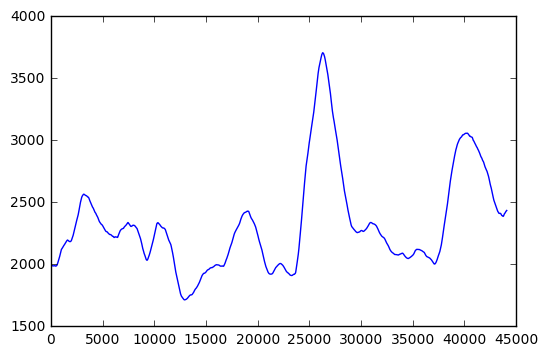

In [185]:
xxtempSampler = Sampler(sakaeClash, Fs/20)

xxtempSampler.reset(longWindow-shortWindow)
xxstartTimbre = power(xxtempSampler.dft[frequencyRange])
xxinitialTimbreAvg = np.array([power(xxtempSampler.next()[frequencyRange]) for i in range(shortWindow-1)])
xxinitialTimbreAvg = np.append([xxstartTimbre], xxinitialTimbreAvg, axis=0)
print xxinitialTimbreAvg.shape
xxtimbreAvg = RollingAverager(xxinitialTimbreAvg)

xxtimbreAvgOverTime = [np.sum(xxtimbreAvg.nextSample(power(xxtempSampler.next()[frequencyRange]))) for i in range(oneSec)]

plt.plot(xxtimbreAvgOverTime)
plt.show()

In [189]:
class NoteExtractorSampler(Sampler):
    def __init__(self, song, N=Fs/20, offset=0, Fs=44100., frequencyCap=4000):
        self.songAvgWindow = 10000
        self.noteAvgWindow = 1000
        
        Sampler.__init__(self, song, N, offset+self.songAvgWindow, Fs)
        self.frequencyRange = (self.frequencies > 0) & (self.frequencies < frequencyCap)
        
        tempSampler = Sampler(song, N, offset, Fs)
        
        # initialize the long averaging window
        startPower = np.sum(power(tempSampler.dft[self.frequencyRange]))
        initialSongAvg = [np.sum(power(tempSampler.next()[self.frequencyRange])) for i in range(self.songAvgWindow-1)]
        initialSongAvg = np.append([startPower], initialSongAvg, axis=0)
        self.songAvg = RollingAverager(initialSongAvg)
        
        # initialize the short averaging window
        tempSampler.reset(offset+self.songAvgWindow-self.noteAvgWindow)
        startTimbre = power(tempSampler.dft[self.frequencyRange])
        initialTimbreAvg = [power(tempSampler.next()[self.frequencyRange]) for i in range(self.noteAvgWindow-1)]
        initialTimbreAvg = np.append([startTimbre], initialTimbreAvg, axis=0)
        self.timbreAvg = RollingAverager(initialTimbreAvg)
        
        self.notes = []
    def nextNote(self):
        self.next()
        currPower = power(self.dft[self.frequencyRange])
        self.songAvg.nextSample(np.sum(currPower)) # increment the averaging windows
        self.timbreAvg.nextSample(currPower)
        
        allNoteFrequencies = []
        # calculate each note's power
        for note in self.notes:
            if (np.sum(self.timbreAvg.average[note]) > self.songAvg.average):
                allNoteFrequencies = np.union1d(allNoteFrequencies, note)
            else:
                self.notes.remove(note) # note below average song power, remove it
        
        # use a boolean mask to exclude all current notes from the frequency spectrum
        mask = np.ones(len(self.frequencies[frequencyRange]), dtype=bool)
        mask[allNoteFrequencies] = False
        
        remainderTopFreqs = self.top50PercentFreqsIndices(self.timbreAvg.average[mask])
        self.remainingPower = np.sum(self.timbreAvg.average[remainderTopFreqs]) # calculate power of top frequencies of remainder
        if (self.remainingPower > self.songAvg.average):
            self.notes.append(remainderTopFreqs) # if above threshold, register as new note
        
        return self.notes
    def top50PercentFreqsIndices(self, timbre): # calculate the top frequencies that add up to 50% of total power
        power50perc = 0.5*np.sum(timbre)
        sortedindices = np.argsort(timbre) # note: ascending order
        sortedtimbre = timbre[sortedindices]
        cumulativeSum = np.cumsum(sortedtimbre)
        return sortedindices[cumulativeSum >= power50perc] # when cumulative sum surpasses 50%, the remaining numbers will sum to 50%

In [197]:
testNoteExtractor = NoteExtractorSampler(sakaeClash)

In [199]:
notesOverTime = []
remainingPowerOverTime = []
timbreAverageOverTime = []
songAverageOverTime = []

for i in range(oneSec*2-testNoteExtractor.songAvgWindow):
    notesOverTime.append(testNoteExtractor.nextNote())
    remainingPowerOverTime.append(testNoteExtractor.remainingPower)
    timbreAverageOverTime.append(np.sum(testNoteExtractor.timbreAvg.average))
    songAverageOverTime.append(testNoteExtractor.songAvg.average)


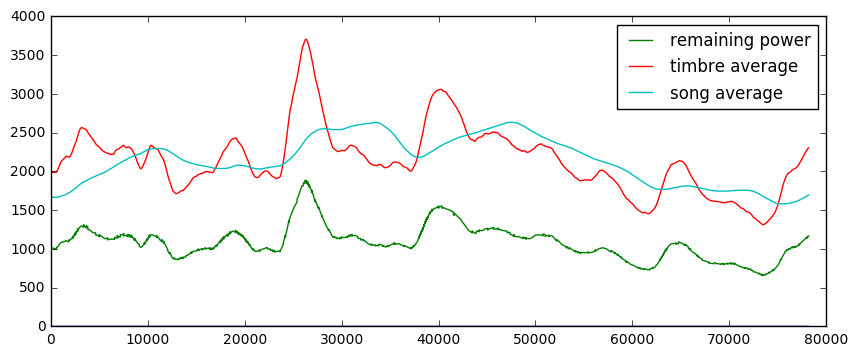

In [203]:
plt.figure(figsize=(10,4))
plt.hold(True)
plt.plot([len(notes) for notes in notesOverTime])
plt.plot(remainingPowerOverTime, label="remaining power")
plt.plot(timbreAverageOverTime, label="timbre average")
plt.plot(songAverageOverTime, label="song average")
plt.legend()
plt.hold(False)
plt.show()

Note how because we calculate remaining power from the frequencies that make up the top 50%, remaining power will always be 50% of the timbre average. Thus, we make some minor fixes

In [35]:
class NoteExtractorSampler2(NoteExtractorSampler):
    def nextNote(self):
        self.next()
        currPower = power(self.dft[self.frequencyRange])
        self.songAvg.nextSample(np.sum(currPower))
        self.timbreAvg.nextSample(currPower)
        
        allNoteFrequencies = []
        # calculate each note's power
        for note in self.notes:
            if (2*np.sum(self.timbreAvg.average[note]) > self.songAvg.average): # multiply by 2, because the top freqs started at 50%
                allNoteFrequencies = np.union1d(allNoteFrequencies, note).astype(int)
            else:
                self.notes.remove(note) # note below average song power, remove it
        
        # use a boolean mask to exclude all current notes from the frequency spectrum
        mask = np.ones(len(self.frequencies[frequencyRange]), dtype=bool)
        mask[allNoteFrequencies] = False
        
        self.remainingPower = np.sum(self.timbreAvg.average[mask]) # calculate remaining power
        if (self.remainingPower > self.songAvg.average):
            remainderTopFreqs = self.top50PercentFreqsIndices(self.timbreAvg.average[mask])
            self.notes.append(remainderTopFreqs.astype(int)) # if above threshold, register as new note
        
        return self.notes

In [37]:
testNoteExtractor = NoteExtractorSampler2(sakaeClash)

In [38]:
firstNoteTopFreqOverTime = []
firstNotePowerOverTime = []
remainingPowerOverTime = []
timbreAverageOverTime = []
songAverageOverTime = []

for i in range(oneSec*2-testNoteExtractor.songAvgWindow):
    notes = testNoteExtractor.nextNote()
    firstNoteTopFreqOverTime.append(notes[0][-1] if len(notes) else 0)
    firstNotePowerOverTime.append(np.sum(testNoteExtractor.timbreAvg.average[notes[0]]) if len(notes) else 0)
    remainingPowerOverTime.append(testNoteExtractor.remainingPower)
    timbreAverageOverTime.append(np.sum(testNoteExtractor.timbreAvg.average))
    songAverageOverTime.append(testNoteExtractor.songAvg.average)


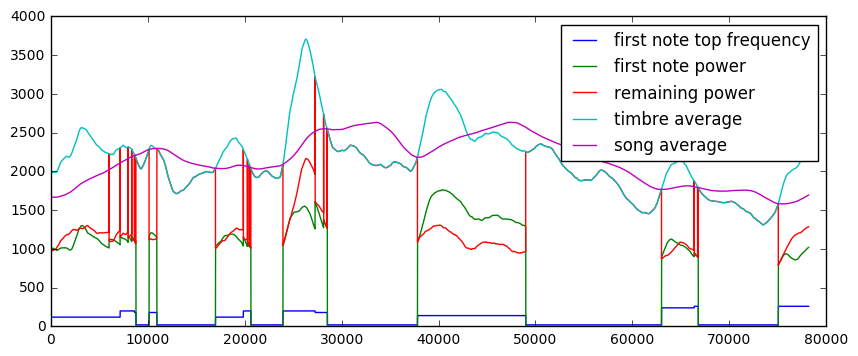

In [39]:
plt.figure(figsize=(10,4))
plt.hold(True)
plt.plot(testNoteExtractor.frequencies[testNoteExtractor.frequencyRange][firstNoteTopFreqOverTime], label="first note top frequency")
plt.plot(firstNotePowerOverTime, label="first note power")
plt.plot(remainingPowerOverTime, label="remaining power")
plt.plot(timbreAverageOverTime, label="timbre average")
plt.plot(songAverageOverTime, label="song average")
plt.legend()
plt.hold(False)
plt.show()

Notice how the remaining power still generally follows the curve of the timbre average, showing that there are still a lot of
frequencies that are part of the note that we are ignoring. Thus, let's try getting the top 90% of notes. In addition, when a note is detected, multiply the note power by 1.2 and use that to determine when the note ends. Not only does this compensate for the loss of power due to only taking the top 90% of frequencies, but it overcompensates, giving a bit of wiggle room.

In [42]:
class NoteExtractorSampler3(NoteExtractorSampler2):
    def nextNote(self):
        self.next()
        currPower = power(self.dft[self.frequencyRange])
        self.songAvg.nextSample(np.sum(currPower))
        self.timbreAvg.nextSample(currPower)
        
        allNoteFrequencies = []
        # calculate each note's power
        for note in self.notes:
            if (1.2*np.sum(self.timbreAvg.average[note]) > self.songAvg.average): # multiply by 1.2, because the top freqs started at 90%
                allNoteFrequencies = np.union1d(allNoteFrequencies, note).astype(int)
            else:
                self.notes.remove(note) # note below average song power, remove it
        
        # use a boolean mask to exclude all current notes from the frequency spectrum
        mask = np.ones(len(self.frequencies[frequencyRange]), dtype=bool)
        mask[allNoteFrequencies] = False
        
        self.remainingPower = np.sum(self.timbreAvg.average[mask]) # calculate remaining power
        if (self.remainingPower > self.songAvg.average):
            remainderTopFreqs = self.top90PercentFreqsIndices(self.timbreAvg.average[mask])
            self.notes.append(remainderTopFreqs.astype(int)) # if above threshold, register as new note
        
        return self.notes
    def top90PercentFreqsIndices(self, timbre):
        power10perc = 0.1*np.sum(timbre)
        sortedindices = np.argsort(timbre) # note: ascending order
        sortedtimbre = timbre[sortedindices]
        cumulativeSum = np.cumsum(sortedtimbre)
        return sortedindices[cumulativeSum >= power10perc] # when cumulative sum surpasses 10%, the remaining numbers will sum to 90%

In [43]:
testNoteExtractor = NoteExtractorSampler3(sakaeClash)

In [44]:
firstNoteTopFreqOverTime = []
firstNotePowerOverTime = []
remainingPowerOverTime = []
timbreAverageOverTime = []
songAverageOverTime = []

for i in range(oneSec*2-testNoteExtractor.songAvgWindow):
    notes = testNoteExtractor.nextNote()
    firstNoteTopFreqOverTime.append(notes[0][-1] if len(notes) else 0)
    firstNotePowerOverTime.append(np.sum(testNoteExtractor.timbreAvg.average[notes[0]]) if len(notes) else 0)
    remainingPowerOverTime.append(testNoteExtractor.remainingPower)
    timbreAverageOverTime.append(np.sum(testNoteExtractor.timbreAvg.average))
    songAverageOverTime.append(testNoteExtractor.songAvg.average)


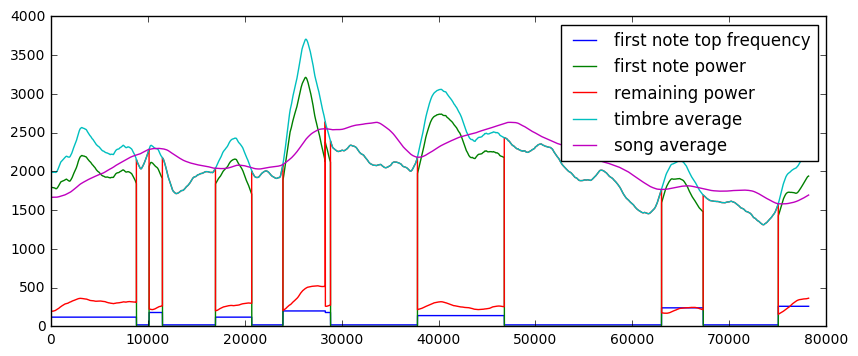

In [45]:
plt.figure(figsize=(10,4))
plt.hold(True)
plt.plot(testNoteExtractor.frequencies[testNoteExtractor.frequencyRange][firstNoteTopFreqOverTime], label="first note top frequency")
plt.plot(firstNotePowerOverTime, label="first note power")
plt.plot(remainingPowerOverTime, label="remaining power")
plt.plot(timbreAverageOverTime, label="timbre average")
plt.plot(songAverageOverTime, label="song average")
plt.legend()
plt.hold(False)
plt.show()

note that there is now less correlation between timbre average and remaining power. Overcompensating also fixed some of the vertical lines in the remaining power graph. Lets overcompensate a little more, but this time lower the song's average power:

In [77]:
class NoteExtractorSampler4(NoteExtractorSampler3):
    def nextNote(self):
        self.next()
        currPower = power(self.dft[self.frequencyRange])
        self.songAvg.nextSample(np.sum(currPower))
        self.timbreAvg.nextSample(currPower)
        
        allNoteFrequencies = []
        # calculate each note's power
        for note in self.notes:
            if (1.2*np.sum(self.timbreAvg.average[note]) > self.songAvg.average*0.9): # multiply by 1.2, because the top freqs started at 90%
                allNoteFrequencies = np.union1d(allNoteFrequencies, note).astype(int)
            else:
                self.notes.remove(note) # note below average song power, remove it
        
        # use a boolean mask to exclude all current notes from the frequency spectrum
        mask = np.ones(len(self.frequencies[frequencyRange]), dtype=bool)
        mask[allNoteFrequencies] = False
        
        self.remainingPower = np.sum(self.timbreAvg.average[mask]) # calculate remaining power
        if (self.remainingPower > self.songAvg.average*0.9):
            remainderTopFreqs = self.top90PercentFreqsIndices(self.timbreAvg.average[mask])
            self.notes.append(remainderTopFreqs.astype(int)) # if above threshold, register as new note
        
        return self.notes

In [72]:
testNoteExtractor = NoteExtractorSampler4(sakaeClash)

In [73]:
firstNoteTopFreqOverTime = []
firstNotePowerOverTime = []
remainingPowerOverTime = []
timbreAverageOverTime = []
songAverageOverTime = []

for i in range(oneSec*2-testNoteExtractor.songAvgWindow):
    notes = testNoteExtractor.nextNote()
    firstNoteTopFreqOverTime.append(notes[0][-1] if len(notes) else 0)
    firstNotePowerOverTime.append(np.sum(testNoteExtractor.timbreAvg.average[notes[0]]) if len(notes) else 0)
    remainingPowerOverTime.append(testNoteExtractor.remainingPower)
    timbreAverageOverTime.append(np.sum(testNoteExtractor.timbreAvg.average))
    songAverageOverTime.append(testNoteExtractor.songAvg.average)


[185 187  63 153 166  73 100 120  64 176 126 178  54  53 125 154 169 158
  57 184 180  74  50  70  48  87  88  45  60  47  86  62 179  56  72 162
  46  84  85  59 159  52  41  98 197  40  99 119 155 156  61  65  49  58
 183 198  42  37  28  36  18  26   0  34  39  17  31  30  27   1  25 182
  16  44  51  35 181   2  32  15  23  24  20  33  12  14  22   7  38   3
  43  29   6  13  21  11  10  19   8   4   9   5]
[ 60 100 130  79  72  85 170  98 197 125 129 111  84 118  51 198 146 160
  82  87  75  64 192  95  66  70 188  61  80 120  40  73 105  56  63 183
 186 194 153 193  68  86 119  54  32  53  96  50  88  71  47 123  59  67
  36  58 106  41 179  65 180  55  33 126  46  52 124  38  48  37 178 177
 185  16   1  39   0  13 159  25 121  31  26 154 182   2 157 122  24  42
  18  29  15  45 156 155  23 181  44  30  20  19   3  34  14  12  35  22
   7  17  10  43  28   4  27   6  21   9  11   8   5]
[ 56 120 133  84 110 125  70 173 176 160 122 148 117 188  62 192 185 144
  68 121   0 158 149

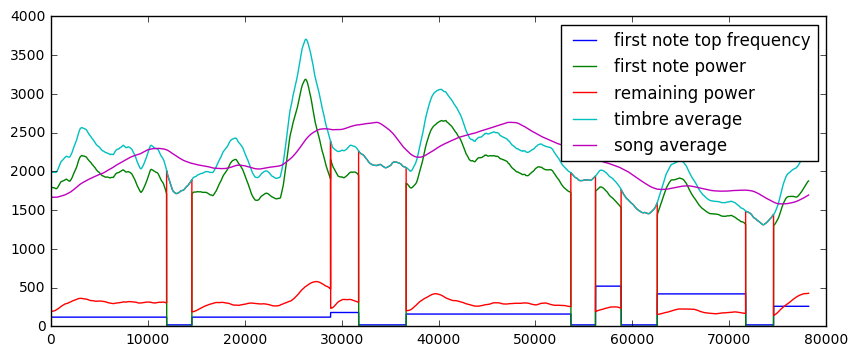

In [74]:
plt.figure(figsize=(10,4))
plt.hold(True)
plt.plot(testNoteExtractor.frequencies[testNoteExtractor.frequencyRange][firstNoteTopFreqOverTime], label="first note top frequency")
plt.plot(firstNotePowerOverTime, label="first note power")
plt.plot(remainingPowerOverTime, label="remaining power")
plt.plot(timbreAverageOverTime, label="timbre average")
plt.plot(songAverageOverTime, label="song average")
plt.legend()
plt.hold(False)
plt.show()

NICE! we have the right amount of notes, even the three piano notes after the clash. However, clearly there are some issues. First, the cymbals section got split into two, with the second part merging into the drum clash. Also, it doesn't seem like we ever captured two notes, probably because the top 90% of frequencies consumes so many frequencies that the remaining power ends up extremely low. However, if we only capture one note at a time, we might as well not use remaining power and just use timbre average. Surprisingly, the remaining power graph seems like it always sort of mirrors the timbre average, so somehow we aren't isolating the note frequencies very well.

Lets try one last part of the song for good luck:

In [80]:
testNoteExtractor = NoteExtractorSampler4(sakae_offset)

Audio(sakae_offset[longWindow:][:2*oneSec-longWindow], rate=Fs)

In [81]:
firstNoteTopFreqOverTime = []
firstNotePowerOverTime = []
remainingPowerOverTime = []
timbreAverageOverTime = []
songAverageOverTime = []

for i in range(oneSec*2-testNoteExtractor.songAvgWindow):
    notes = testNoteExtractor.nextNote()
    firstNoteTopFreqOverTime.append(notes[0][-1] if len(notes) else 0)
    firstNotePowerOverTime.append(np.sum(testNoteExtractor.timbreAvg.average[notes[0]]) if len(notes) else 0)
    remainingPowerOverTime.append(testNoteExtractor.remainingPower)
    timbreAverageOverTime.append(np.sum(testNoteExtractor.timbreAvg.average))
    songAverageOverTime.append(testNoteExtractor.songAvg.average)


[array([ 95, 104, 135,   1,  93,  94,   3, 132,   4,  83,  80, 134,  92,
       129,  81, 133, 130,  84,  79,   5,  82,  37,  59,  35,  58,  61,
        57,  60,  85,   6,  91,  78,   0,  36,  18,  77,   7, 131,  56,
        24,  39,  76,  38,  29,  34,  33,  74,  75,  55,  73,  63,  72,
        62,  86,  28,  50,  16,  10,   9,  49,  17,  27,  40,  51,   8,
        48,  54,  20,  53,  11,  47,  52,  15,  71,  23,  70,  25,  30,
        41,  69,  19,  26,  46,  68,  21,  67,  66,  22,  90,  65,  31,
        64,  45,  13,  14,  42,  12,  89,  32,  87,  88,  44,  43])]
[array([ 53,  76,  77, 130,  54,   0,   2,  45,  41,  49, 118,  74,  39,
        73,   3,  40,  72,   5,  55,   6,  71,  38,   4,  48,  42,  56,
       129,  70,   7, 103,  60,  87,  44,  69,  59,  61,  57,  10,  88,
        12,   8,  37,  68,  36,  62,  43,  35,  34,  11,  58,  23,  21,
        16,  33,  67,  17,  30,  25,  26,  22,  24,  63,  20,  14,  15,
         9,  32,  64,  13,  31,  65,  18,  27,  66,  28,  19,  29

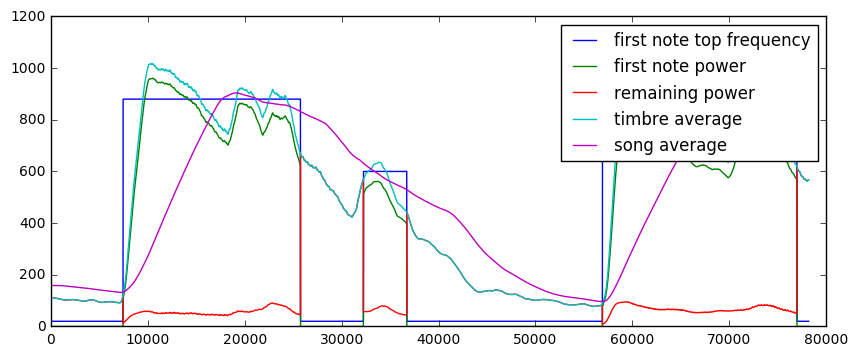

In [82]:
plt.figure(figsize=(10,4))
plt.hold(True)
plt.plot(testNoteExtractor.frequencies[testNoteExtractor.frequencyRange][firstNoteTopFreqOverTime], label="first note top frequency")
plt.plot(firstNotePowerOverTime, label="first note power")
plt.plot(remainingPowerOverTime, label="remaining power")
plt.plot(timbreAverageOverTime, label="timbre average")
plt.plot(songAverageOverTime, label="song average")
plt.legend()
plt.hold(False)
plt.show()

In [59]:
testNoteExtractor = NoteExtractorSampler4(rawsakae1[75*oneSec:])

Audio(rawsakae1[75*oneSec+longWindow:][:2*oneSec-longWindow], rate=Fs)

In [53]:
firstNoteTopFreqOverTime = []
firstNotePowerOverTime = []
remainingPowerOverTime = []
timbreAverageOverTime = []
songAverageOverTime = []

for i in range(oneSec*2-testNoteExtractor.songAvgWindow):
    notes = testNoteExtractor.nextNote()
    firstNoteTopFreqOverTime.append(notes[0][-1] if len(notes) else 0)
    firstNotePowerOverTime.append(np.sum(testNoteExtractor.timbreAvg.average[notes[0]]) if len(notes) else 0)
    remainingPowerOverTime.append(testNoteExtractor.remainingPower)
    timbreAverageOverTime.append(np.sum(testNoteExtractor.timbreAvg.average))
    songAverageOverTime.append(testNoteExtractor.songAvg.average)


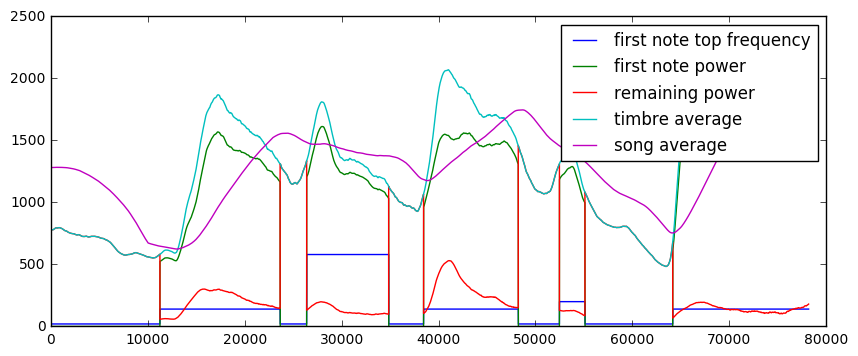

In [54]:
plt.figure(figsize=(10,4))
plt.hold(True)
plt.plot(testNoteExtractor.frequencies[testNoteExtractor.frequencyRange][firstNoteTopFreqOverTime], label="first note top frequency")
plt.plot(firstNotePowerOverTime, label="first note power")
plt.plot(remainingPowerOverTime, label="remaining power")
plt.plot(timbreAverageOverTime, label="timbre average")
plt.plot(songAverageOverTime, label="song average")
plt.legend()
plt.hold(False)
plt.show()

Lets look at a place where two instruments are played continuously on top of eachother

In [61]:
testNoteExtractor = NoteExtractorSampler4(rawsakae1[107*oneSec:])

Audio(rawsakae1[107*oneSec+longWindow:][:2*oneSec-longWindow], rate=Fs)

In [62]:
firstNoteTopFreqOverTime = []
firstNotePowerOverTime = []
remainingPowerOverTime = []
timbreAverageOverTime = []
songAverageOverTime = []

for i in range(oneSec*2-testNoteExtractor.songAvgWindow):
    notes = testNoteExtractor.nextNote()
    firstNoteTopFreqOverTime.append(notes[0][-1] if len(notes) else 0)
    firstNotePowerOverTime.append(np.sum(testNoteExtractor.timbreAvg.average[notes[0]]) if len(notes) else 0)
    remainingPowerOverTime.append(testNoteExtractor.remainingPower)
    timbreAverageOverTime.append(np.sum(testNoteExtractor.timbreAvg.average))
    songAverageOverTime.append(testNoteExtractor.songAvg.average)


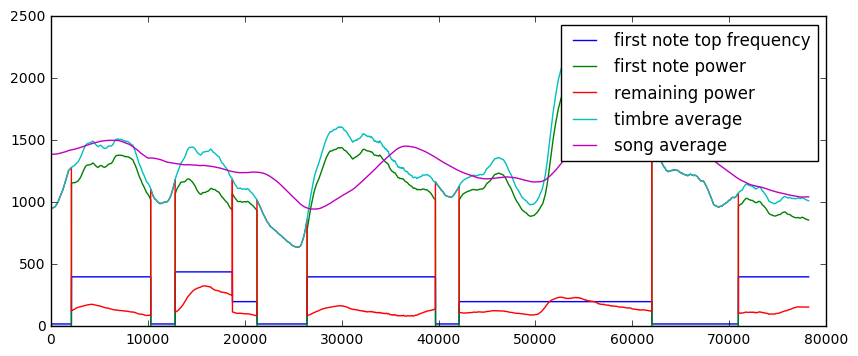

In [63]:
plt.figure(figsize=(10,4))
plt.hold(True)
plt.plot(testNoteExtractor.frequencies[testNoteExtractor.frequencyRange][firstNoteTopFreqOverTime], label="first note top frequency")
plt.plot(firstNotePowerOverTime, label="first note power")
plt.plot(remainingPowerOverTime, label="remaining power")
plt.plot(timbreAverageOverTime, label="timbre average")
plt.plot(songAverageOverTime, label="song average")
plt.legend()
plt.hold(False)
plt.show()

### Full Range Spectrometer

In [ ]:
lowClashSampler.reset()

humanHearing = np.nonzero((lowClashSampler.frequencies > 20) & (lowClashSampler.frequencies < 20000))[0]

average_over = 10 # average the data over 10 samples
spectrum = np.zeros((int(oneSec*2/average_over), len(humanHearing)))
for i in range(int(oneSec*2/average_over)):
    spectrum[i] = np.mean([power(lowClashSampler.next()[humanHearing]) for j in range(average_over)], axis=0)

spectrum = interpolation.zoom(spectrum, [0.2,1])
spectrum.shape

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(spectrum.T, aspect='auto', interpolation='none', extent=[0,2,20000,0]) #np.linspace(0,2,oneSec*2,endpoint=False),
#plt.colorbar()
plt.gca().invert_yaxis()
plt.show()

compare this with the one at [academo.org/demos/spectrum-analyzer](https://academo.org/demos/spectrum-analyzer/). How come theirs looks so much better?